# NASA Marine Debris Dataset for Object Detection in Planetscope Imagery 

## Background

- Downloaded the **NASA Marine Debris Dataset for Object Detection in Planetscope Imagery** from https://mlhub.earth/data/nasa_marine_debris as `nasa_marine_debris_labels.geojson`.
- Loaded the `nasa_marine_debris_labels.geojson` into QGIS. For Africa the data is only available off the coast of Ghana.
- Drew a bounding box around the data available off the coast of Ghana and exported the layer as `nasa_marine_debris_labels_ghana_bounding_box.geojson`.
- Clipped the `nasa_marine_debris_labels.geojson` using the `nasa_marine_debris_labels_ghana_bounding_box.geojson` and exported the data as `nasa_marine_debris_labels_ghana.geojson`.
- Downloaded the corresponding Planet scope source imagery for the `nasa_marine_debris_labels_ghana.geojson` from https://mlhub.earth/data/nasa_marine_debris 
- In QGIS, for each polygon in the `nasa_marine_debris_labels_ghana.geojson` dataset, sampled a minimum of 1 point and saved the corresponding dataset as `nasa_marine_debris_points_ghana.geojson.`


 ## Results
- Calculating the FDI using the approach used in the [Floating Marine Debris notebook](Explore_Floating_Marine_Debris_Data.ipynb) produces good results.
- For the NASA Marine Debris Dataset since the marine debris datasets are polygons we can clearly see the FDI derived from the Sentinel-2 image dated `2018-10-31` performs well visually.
- Because the NASA Marine Debris Dataset polygons did not overlay properly with the Sentinel-2 FDI image for `2018-10-31`, possible marine debris points were sampled from the Sentinel-2 FDI image and saved as `nasa_marine_debris.geojson`. 

In [1]:
# Load the necessary python packages. 
%matplotlib inline
import os
import datacube

from datetime import datetime, timedelta
from matplotlib import colors as mcolors
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from datacube.utils.geometry import Geometry
from datacube.utils.cog import write_cog

from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard, wofs_fuser, mostcommon_crs
from deafrica_tools.spatial import xr_rasterize

from fdi_functions import *

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
# Connect the datacube.
dc = datacube.Datacube(app='Floating Marine Debris')

In [3]:
# Define the analysis parametres.

country = "ghana"

# File path for the area of interest to load Sentinel-2 imagery for.
aoi_fp = f"data/nasa_marine_debris_labels_{country}_bounding_box.geojson"

# File path to the NASA Marine Debris Dataset for Object Detection in Planetscope Imagery dataset. 
marine_debris_fp = f"data/nasa_marine_debris_labels_{country}.geojson" #f"data/nasa_marine_debris_points_{country}.geojson"

# Time from the Planetscope scene the marine debris was labeled on.
time_range = ("2018-10-31")

# Statistic to use to sample the Sentinel-2 imagery.
stats = "mean"

output_crs = "EPSG:6933"
resolution = (-10, 10)

s2_measurements = ['blue', 'green', 'red','red_edge_2', 'nir', 'swir_1']

s2_aliases = {'B4': 'red',
              'B6': 'red_edge_2',
              'B8': 'nir',
              'B11': 'swir_1'}


# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)


# Define the color map to use when plotting. 
cmap = plt.get_cmap('tab20', 20)
color_list = [mcolors.rgb2hex(cmap(i)[:3]) for i in range(cmap.N)]

In [4]:
# Load the area of interest.
aoi_gdf = gpd.read_file(aoi_fp)

# Convert the area of interest GeoDataFrame to a Geometry object.
geopolygon = Geometry(geom=aoi_gdf.iloc[0].geometry, crs=aoi_gdf.crs)

# Reproject the area of interest to the output_crs.
aoi_gdf = aoi_gdf.to_crs(output_crs)

In [5]:
# Load the NASA Marine Debris Dataset for Object Detection in Planetscope Imagery dataset. .
marine_debris_dataset = gpd.read_file(marine_debris_fp)
#marine_debris_dataset.drop(columns="id", inplace=True)

In [6]:
# Reproject the marine_debris_dataset GeoDataFrame to the output crs.
marine_debris_dataset = marine_debris_dataset.to_crs(output_crs)

marine_debris_dataset.head()

,earth_science_event,tag_status,label,metadata,name,labels,geometry
0,Marine Debris,yes,shapefile85872_20181031_095925_103b,{'': ''},marine_debris,1,"MULTIPOLYGON (((-30483.779 700504.265, -30420...."
1,Marine Debris,yes,shapefile85873_20181031_095925_103b,{'': ''},marine_debris,1,"MULTIPOLYGON (((-30651.858 700403.426, -30583...."
2,Marine Debris,yes,shapefile85871_20181031_095925_103b,{'': ''},marine_debris,1,"MULTIPOLYGON (((-30212.459 700652.857, -30210...."
3,Marine Debris,yes,shapefile85870_20181031_095925_103b,{'': ''},marine_debris,1,"MULTIPOLYGON (((-30314.156 700624.155, -30243...."
4,Marine Debris,yes,shapefile85878_20181031_095925_103b,{'': ''},marine_debris,1,"MULTIPOLYGON (((-27843.142 700409.649, -27843...."


In [7]:
# Create a reusable datacube query.
query = dict(measurements=s2_measurements,
             geopolygon=geopolygon,
             time=time_range,
             resolution=resolution,
             output_crs=output_crs,
             group_by="solar_day")

In [8]:
# Load Sentinel-2 data using 'dc.load'.
ds_s2 = dc.load(product=["s2_l2a"],
                **query
                )

# Mask the Sentinel 2 dataset to the area of interest. 
mask = xr_rasterize(aoi_gdf, ds_s2)
ds_s2 = ds_s2.where(mask)

# Normalize the bands.
ds_s2 = normalize_intensity(ds_s2)

# Calculate the required spectral indices.
ds_s2 =  insert_indices(ds_s2)

print(ds_s2)

<xarray.Dataset>
Dimensions:      (time: 1, y: 1633, x: 1538)
Coordinates:
  * time         (time) datetime64[ns] 2018-10-31T10:19:11
  * y            (y) float64 7.068e+05 7.068e+05 ... 6.905e+05 6.905e+05
  * x            (x) float64 -3.416e+04 -3.416e+04 ... -1.880e+04 -1.88e+04
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    green        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    red          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    red_edge_2   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    nir          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    swir_1       (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FAI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    FDI          (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    PI           (time, y, x) float64 nan nan nan

In [9]:
affine = ds_s2.geobox.affine
crs = ds_s2.geobox.crs

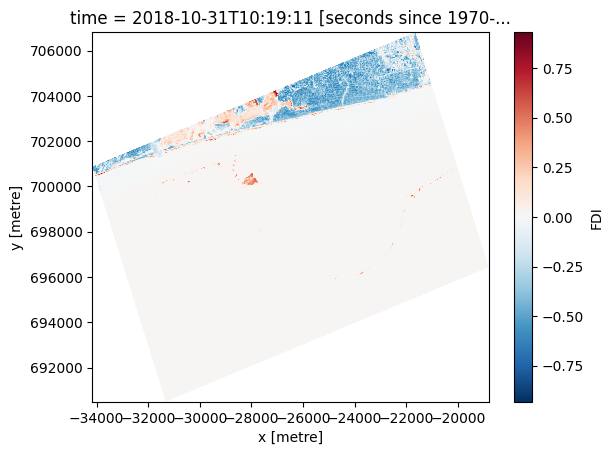

In [10]:
ds = ds_s2["FDI"].squeeze()

# Write the dataset to a GeoTIFF.
#write_cog(ds,
#          fname=f"results/s2_{country}_FDI_{time_range}.tif",
#          overwrite=True)

ds.plot(cmap="RdBu_r")

<AxesSubplot: title={'center': 'time = 2018-10-31T10:19:11 [seconds since 1970-...'}, xlabel='x [metre]', ylabel='y [metre]'>

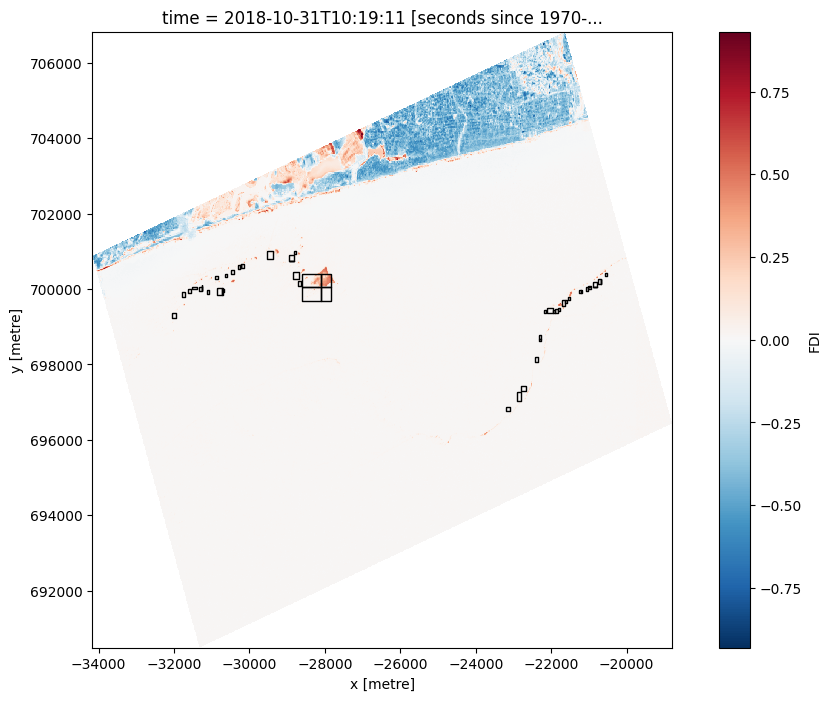

In [11]:
# Overlay the sentinel -2 image with the marine debris dataset polygons. 

fig, ax = plt.subplots(figsize=(12,8))
ds.plot(cmap="RdBu_r", ax=ax)
marine_debris_dataset.plot(ax=ax, facecolor="none")

In [12]:
# Load the marine_debris.geojson file.
marine_plastics_training_dataset = gpd.read_file("data/nasa_marine_debris.geojson")

marine_plastics_training_dataset["Country"] = country
marine_plastics_training_dataset["Sentinel-2 image date"] = time_range

In [13]:
statistics = zonal_stats(marine_plastics_training_dataset, 
                         ds_s2.sel(time=marine_plastics_training_dataset["Sentinel-2 image date"].unique().item()).squeeze()["FDI"].values, 
                         affine=affine, stats=[stats], 
                         nodata=np.nan)

marine_plastics_training_dataset[f"FDI"] = [i[stats] for i in statistics]
marine_plastics_training_dataset.head()

,FDI,geometry,Country,Sentinel-2 image date
0,0.010405,POINT (-31997.210 699299.172),ghana,2018-10-31
1,0.016097,POINT (-31742.810 699843.998),ghana,2018-10-31
2,0.007137,POINT (-31587.394 699950.626),ghana,2018-10-31
3,0.011470,POINT (-31464.745 700051.863),ghana,2018-10-31
4,0.011539,POINT (-31300.454 700012.626),ghana,2018-10-31


In [14]:
# Save the dataset to a geojson file
marine_plastics_training_dataset.to_file(f"data/{country}_nasa_marine_debris_training_dataset.geojson", driver="GeoJSON")